Our solver will solve the Navier Stokes equations in two dimensions to calculate the velocities at each grid point and then move to the next time step. The continuity equation will be used as a governing equation for pressure by some manipulation. Hence the we will solve the following equations in theory:
$$
\begin{equation}
    \cfrac{\partial u}{\partial x} +\cfrac{\partial v}{\partial y}=0
\end{equation}\\
\begin{equation}
    \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right)
\end{equation}\\
\begin{equation}
    \frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) 
\end{equation}
$$
But since we do not have an explicit governing equation for pressure, we will take the divergence of the momentum equations, add them and use the continuity equation to eliminate the $\cfrac{\partial u}{\partial x} +\cfrac{\partial v}{\partial y}$ terms in the equations, to get the pressure poisson equation, given by,
$$
\begin{equation}
    \frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)
\end{equation}
$$
This equation essentially ensures that continuity is satisfied at the current time step and also couples the pressure and velocities together. 


## Constants and initial conditions

In [34]:
import numpy as np
from matplotlib import pyplot as plt, cm
from solver import *
%matplotlib inline

lx = 5      #length in the x direction
ly = 1      #length in the y direction
nx = 51     #grid points in x direction
ny = 21     #grid points in y direction
t = 1       #final time to calculate to
dx = lx / (nx - 1)
dy = ly / (ny - 1)
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001 #time step size
nt=int(t/dt)

u = np.zeros((ny, nx)) #initial conditions 
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 

For the boundary conditions, use 'N' for Neumann BC or 'D' for dirichlet, followed by the prescribed value of the gradient/variable at the boundary

## Solving the equations

In [35]:
u = np.zeros((ny, nx)) #comment out these four lines if you want to run from last time step
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

#imposing boundary conditions

#PRESSURE
pLeft=['N',0]
pRight=['D',0]
pTop=['N',0]
pBottom=['N',0]

pBCs=[pLeft,pRight,pTop,pBottom]
#pressureBC(pLeft,pRight,pTop,pBottom,p,dx,dy)

#VELOCITY

#x-component
uLeft=['D',1]
uRight=['N',0]
uTop=['D',0]
uBottom=['D',0]

uBCs=[uLeft,uRight,uTop,uBottom]
#XVelBC(uLeft,uRight,uTop,uBottom,u,dx,dy)

#y-component
vLeft=['D',0]
vRight=['D',0]
vTop=['D',0]
vBottom=['D',0]

#YVelBC(vLeft,vRight,vTop,vBottom,v,dx,dy)
vBCs=[vLeft,vRight,vTop,vBottom]
# solving
u, v, p = flow_solver(nt, u, v, dt, dx, dy, p, rho, nu, pBCs, uBCs, vBCs)

## Plotting the results

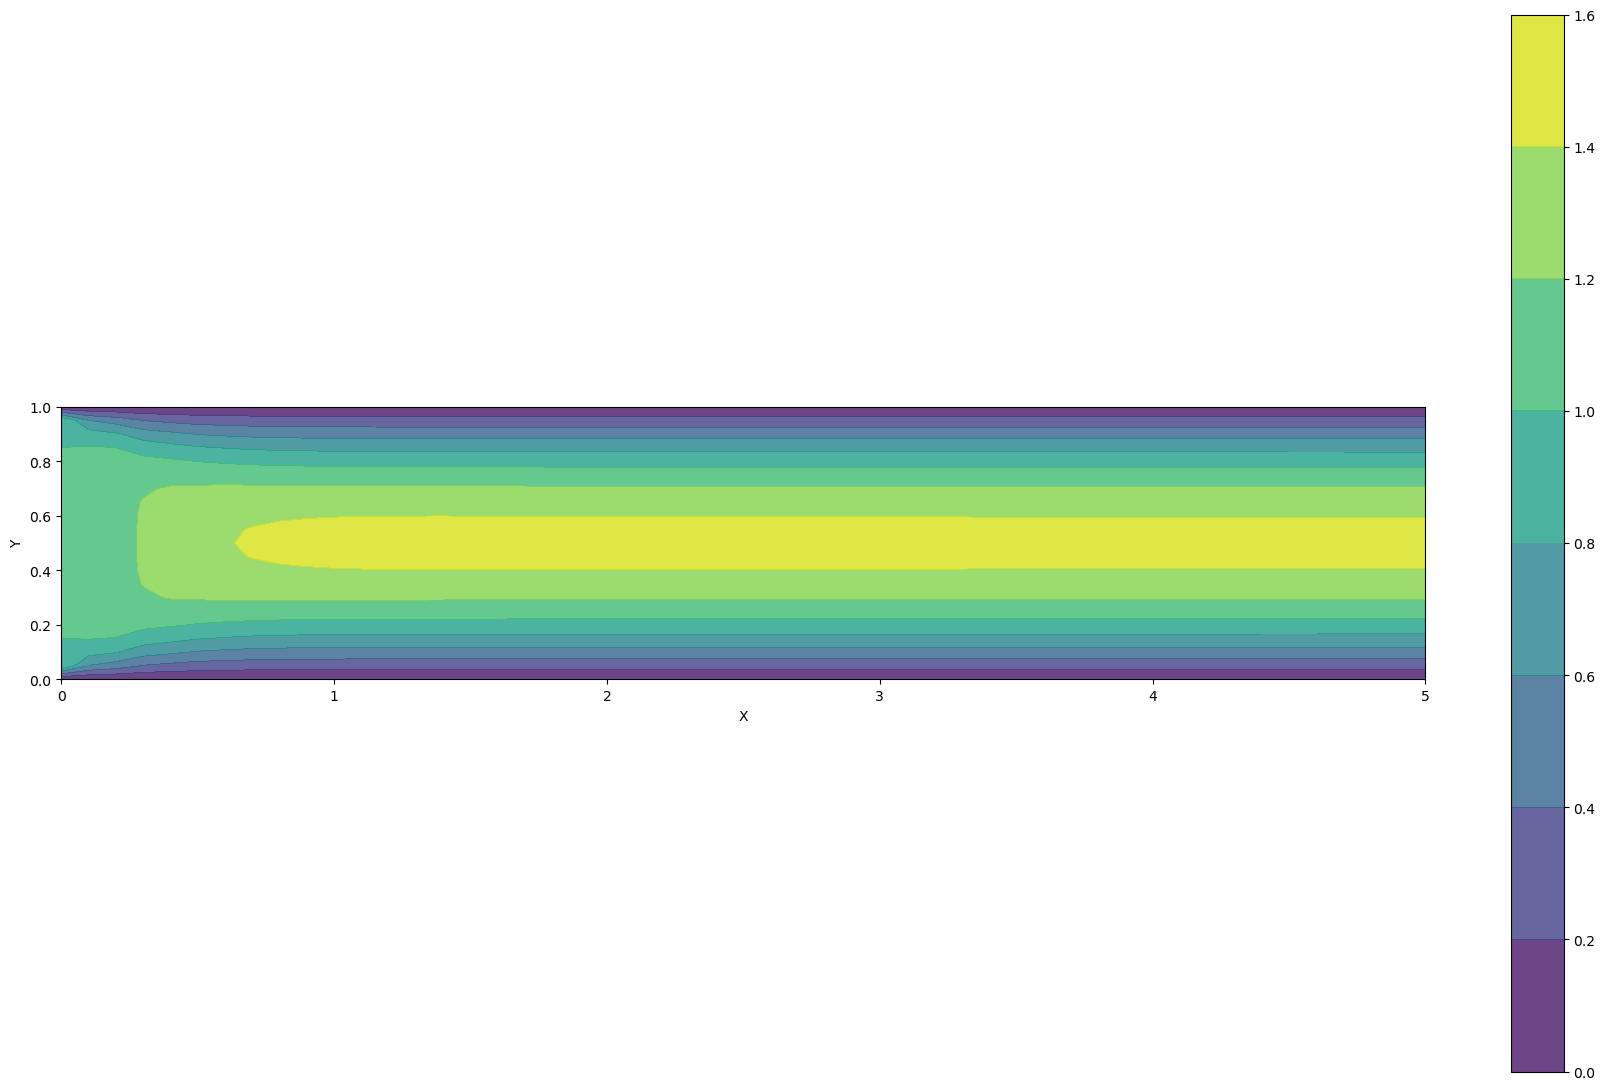

In [36]:
fig = plt.figure(figsize=(22,14),dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, u, alpha=0.8, cmap=cm.viridis)  
plt.colorbar()
## plotting the pressure field outlines
#plt.contour(X, Y, p, cmap=cm.viridis)  
## plotting velocity field
#plt.quiver(X[::lx, ::2*ly], Y[::lx, ::2*ly], u[::lx, ::2*ly], v[::lx, ::2*ly]) 
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

<ipython-input-37-c7c19ca058d0>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, u, alpha=0.8, cmap=cm.viridis)


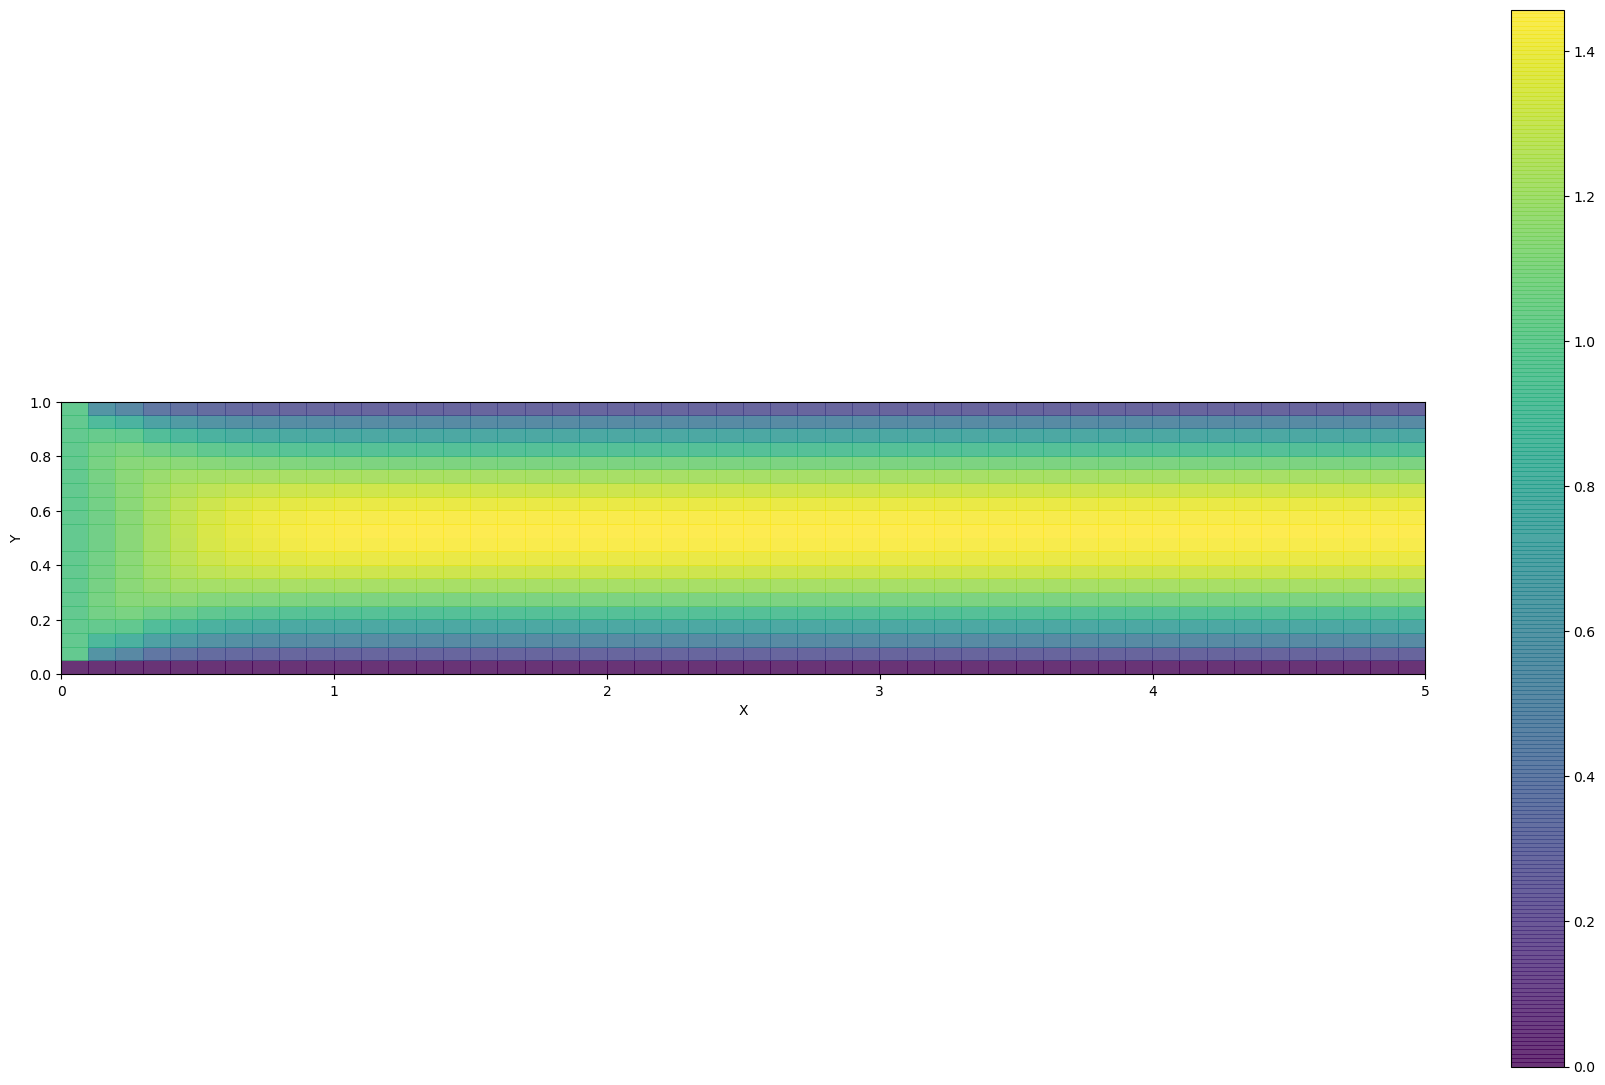

In [37]:
fig = plt.figure(figsize=(22,14),dpi=100)
# plotting the pressure field as a contour
#plt.contourf(X, Y, u, alpha=0.8, cmap=cm.viridis)
## plotting the pressure field outlines
plt.pcolormesh(X, Y, u, alpha=0.8, cmap=cm.viridis)
plt.colorbar()
## plotting velocity field
#plt.streamplot(X[::lx, ::2*ly], Y[::lx, ::2*ly], u[::lx, ::2*ly], v[::lx, ::2*ly])
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
ax.set_aspect(1)
plt.show()